# Distilling Knowledge in Neural Network

The term "Knowledge Distillation" (a.k.a Teacher-Student Model) was first introduced by (Bu-cilu et al., 2006; Ba & Caruana,2014) and has been popularized by (Hinton et al., 2015), as a way to let smaller deep learning models learn how bigger ones generalize to large datasets, hence increase the performance of the smaller one. In this notebook, I'll try to explain the idea of knowledge distillation alongside with hands-on implementation of it.

# The main idea


# Install and import requirements


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import seaborn as sns

#  Load and preprocess the data

In [ ]:
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape each example to WIDTH*HEIGHT*CHANNELS for Convolution operation
# x_test = x_test.reshape(-1,,28,1)
# x_train = x_train.reshape(-1,28,28,1)


170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


# Create teacher model

In [ ]:
Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Take a look at the model summary

Teacher.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 256)               1

In [ ]:
myCP = ModelCheckpoint(save_best_only=True,filepath='teacher.h5',monitor = 'val_acc')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=40,
         validation_split = 0.2,
         callbacks=[myCP])

Epoch 1/40
313/313 [==============================] - ETA: 0s - loss: 1.7092 - accuracy: 0.3765

313/313 [==============================] - 8s 10ms/step - loss: 1.7092 - accuracy: 0.3765 - val_loss: 1.3792 - val_accuracy: 0.5143
Epoch 2/40
305/313 [============================>.] - ETA: 0s - loss: 1.3654 - accuracy: 0.5082

313/313 [==============================] - 2s 6ms/step - loss: 1.3649 - accuracy: 0.5084 - val_loss: 1.2302 - val_accuracy: 0.5833
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 1.2445 - accuracy: 0.5546

313/313 [==============================] - 2s 6ms/step - loss: 1.2445 - accuracy: 0.5546 - val_loss: 1.1149 - val_accuracy: 0.6072
Epoch 4/40
313/313 [==============================] - ETA: 0s - loss: 1.1583 - accuracy: 0.5868

313/313 [==============================] - 2s 6ms/step - loss: 1.1583 - accuracy: 0.5868 - val_loss: 1.0650 - val_accuracy: 0.6286
Epoch 5/40
306/313 [============================>.] - ETA: 0s - loss: 1.0892 - accuracy: 0.6121

313/313 [==============================] - 2s 7ms/step - loss: 1.0899 - accuracy: 0.6117 - val_loss: 1.0177 - val_accuracy: 0.6424
Epoch 6/40
305/313 [============================>.] - ETA: 0s - loss: 1.0315 - accuracy: 0.6367

313/313 [==============================] - 2s 7ms/step - loss: 1.0314 - accuracy: 0.6364 - val_loss: 0.9874 - val_accuracy: 0.6516
Epoch 7/40
306/313 [============================>.] - ETA: 0s - loss: 0.9836 - accuracy: 0.6517

313/313 [==============================] - 2s 7ms/step - loss: 0.9822 - accuracy: 0.6522 - val_loss: 0.9573 - val_accuracy: 0.6616
Epoch 8/40
308/313 [============================>.] - ETA: 0s - loss: 0.9423 - accuracy: 0.6667

313/313 [==============================] - 2s 6ms/step - loss: 0.9433 - accuracy: 0.6661 - val_loss: 0.9628 - val_accuracy: 0.6623
Epoch 9/40
305/313 [============================>.] - ETA: 0s - loss: 0.9039 - accuracy: 0.6818

313/313 [==============================] - 2s 6ms/step - loss: 0.9031 - accuracy: 0.6822 - val_loss: 0.9039 - val_accuracy: 0.6846
Epoch 10/40
310/313 [============================>.] - ETA: 0s - loss: 0.8597 - accuracy: 0.6961

313/313 [==============================] - 2s 6ms/step - loss: 0.8598 - accuracy: 0.6960 - val_loss: 0.8856 - val_accuracy: 0.6917
Epoch 11/40
309/313 [============================>.] - ETA: 0s - loss: 0.8398 - accuracy: 0.7036

313/313 [==============================] - 2s 6ms/step - loss: 0.8391 - accuracy: 0.7038 - val_loss: 0.8774 - val_accuracy: 0.6955
Epoch 12/40
308/313 [============================>.] - ETA: 0s - loss: 0.7941 - accuracy: 0.7179

313/313 [==============================] - 2s 6ms/step - loss: 0.7943 - accuracy: 0.7175 - val_loss: 0.8966 - val_accuracy: 0.6920
Epoch 13/40
311/313 [============================>.] - ETA: 0s - loss: 0.7656 - accuracy: 0.7284

313/313 [==============================] - 2s 7ms/step - loss: 0.7655 - accuracy: 0.7286 - val_loss: 0.8554 - val_accuracy: 0.7020
Epoch 14/40
305/313 [============================>.] - ETA: 0s - loss: 0.7341 - accuracy: 0.7393

313/313 [==============================] - 2s 6ms/step - loss: 0.7339 - accuracy: 0.7394 - val_loss: 0.8662 - val_accuracy: 0.7008
Epoch 15/40
308/313 [============================>.] - ETA: 0s - loss: 0.7011 - accuracy: 0.7502

313/313 [==============================] - 2s 6ms/step - loss: 0.7012 - accuracy: 0.7502 - val_loss: 0.8539 - val_accuracy: 0.7085
Epoch 16/40
312/313 [============================>.] - ETA: 0s - loss: 0.6826 - accuracy: 0.7579

313/313 [==============================] - 2s 6ms/step - loss: 0.6825 - accuracy: 0.7579 - val_loss: 0.8416 - val_accuracy: 0.7122
Epoch 17/40
310/313 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.7667

313/313 [==============================] - 2s 6ms/step - loss: 0.6534 - accuracy: 0.7667 - val_loss: 0.8654 - val_accuracy: 0.7056
Epoch 18/40
307/313 [============================>.] - ETA: 0s - loss: 0.6273 - accuracy: 0.7736

313/313 [==============================] - 2s 6ms/step - loss: 0.6270 - accuracy: 0.7737 - val_loss: 0.8473 - val_accuracy: 0.7170
Epoch 19/40
306/313 [============================>.] - ETA: 0s - loss: 0.6119 - accuracy: 0.7774

313/313 [==============================] - 2s 7ms/step - loss: 0.6115 - accuracy: 0.7782 - val_loss: 0.8650 - val_accuracy: 0.7108
Epoch 20/40
312/313 [============================>.] - ETA: 0s - loss: 0.5831 - accuracy: 0.7911

313/313 [==============================] - 2s 6ms/step - loss: 0.5830 - accuracy: 0.7911 - val_loss: 0.8636 - val_accuracy: 0.7163
Epoch 21/40
306/313 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.7997

313/313 [==============================] - 2s 6ms/step - loss: 0.5527 - accuracy: 0.7995 - val_loss: 0.8809 - val_accuracy: 0.7171
Epoch 22/40
308/313 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.8058

313/313 [==============================] - 2s 6ms/step - loss: 0.5366 - accuracy: 0.8057 - val_loss: 0.8667 - val_accuracy: 0.7152
Epoch 23/40
304/313 [============================>.] - ETA: 0s - loss: 0.5174 - accuracy: 0.8086

313/313 [==============================] - 2s 6ms/step - loss: 0.5171 - accuracy: 0.8090 - val_loss: 0.8665 - val_accuracy: 0.7178
Epoch 24/40
313/313 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8224

313/313 [==============================] - 2s 6ms/step - loss: 0.4931 - accuracy: 0.8224 - val_loss: 0.9025 - val_accuracy: 0.7154
Epoch 25/40
306/313 [============================>.] - ETA: 0s - loss: 0.4734 - accuracy: 0.8272

313/313 [==============================] - 2s 7ms/step - loss: 0.4745 - accuracy: 0.8267 - val_loss: 0.9113 - val_accuracy: 0.7137
Epoch 26/40
305/313 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.8317

313/313 [==============================] - 2s 6ms/step - loss: 0.4655 - accuracy: 0.8317 - val_loss: 0.9237 - val_accuracy: 0.7138
Epoch 27/40
312/313 [============================>.] - ETA: 0s - loss: 0.4402 - accuracy: 0.8389

313/313 [==============================] - 2s 6ms/step - loss: 0.4402 - accuracy: 0.8389 - val_loss: 0.9289 - val_accuracy: 0.7179
Epoch 28/40
313/313 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8426

313/313 [==============================] - 2s 6ms/step - loss: 0.4274 - accuracy: 0.8426 - val_loss: 0.9911 - val_accuracy: 0.7131
Epoch 29/40
306/313 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.8495

313/313 [==============================] - 2s 6ms/step - loss: 0.4088 - accuracy: 0.8491 - val_loss: 0.9775 - val_accuracy: 0.7014
Epoch 30/40
305/313 [============================>.] - ETA: 0s - loss: 0.3927 - accuracy: 0.8577

313/313 [==============================] - 2s 6ms/step - loss: 0.3940 - accuracy: 0.8571 - val_loss: 0.9772 - val_accuracy: 0.7130
Epoch 31/40
309/313 [============================>.] - ETA: 0s - loss: 0.3777 - accuracy: 0.8621

313/313 [==============================] - 2s 7ms/step - loss: 0.3779 - accuracy: 0.8620 - val_loss: 1.0213 - val_accuracy: 0.7108
Epoch 32/40
310/313 [============================>.] - ETA: 0s - loss: 0.3630 - accuracy: 0.8678

313/313 [==============================] - 2s 6ms/step - loss: 0.3627 - accuracy: 0.8679 - val_loss: 1.0282 - val_accuracy: 0.7149
Epoch 33/40
305/313 [============================>.] - ETA: 0s - loss: 0.3423 - accuracy: 0.8729

313/313 [==============================] - 2s 6ms/step - loss: 0.3428 - accuracy: 0.8728 - val_loss: 1.0942 - val_accuracy: 0.7092
Epoch 34/40
307/313 [============================>.] - ETA: 0s - loss: 0.3389 - accuracy: 0.8769

313/313 [==============================] - 2s 6ms/step - loss: 0.3389 - accuracy: 0.8770 - val_loss: 1.0439 - val_accuracy: 0.7185
Epoch 35/40
305/313 [============================>.] - ETA: 0s - loss: 0.3311 - accuracy: 0.8769

313/313 [==============================] - 2s 6ms/step - loss: 0.3308 - accuracy: 0.8770 - val_loss: 1.1099 - val_accuracy: 0.7073
Epoch 36/40
313/313 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8814

313/313 [==============================] - 2s 6ms/step - loss: 0.3185 - accuracy: 0.8814 - val_loss: 1.0929 - val_accuracy: 0.7148
Epoch 37/40
313/313 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.8850

313/313 [==============================] - 2s 7ms/step - loss: 0.3098 - accuracy: 0.8850 - val_loss: 1.0882 - val_accuracy: 0.7116
Epoch 38/40
312/313 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8898

313/313 [==============================] - 2s 7ms/step - loss: 0.2997 - accuracy: 0.8898 - val_loss: 1.0881 - val_accuracy: 0.7143
Epoch 39/40
306/313 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8937

313/313 [==============================] - 2s 6ms/step - loss: 0.2882 - accuracy: 0.8935 - val_loss: 1.1529 - val_accuracy: 0.7157
Epoch 40/40
306/313 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8939

313/313 [==============================] - 2s 6ms/step - loss: 0.2811 - accuracy: 0.8941 - val_loss: 1.1569 - val_accuracy: 0.7121


In [ ]:
# Retrieve best model from saved
#Teacher = load_model('teacher.h5')

# Evaluation with test set
Teacher.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.1592 - accuracy: 0.7080


[1.1591572761535645, 0.7080000042915344]

# Understand temperature

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 71ms/step


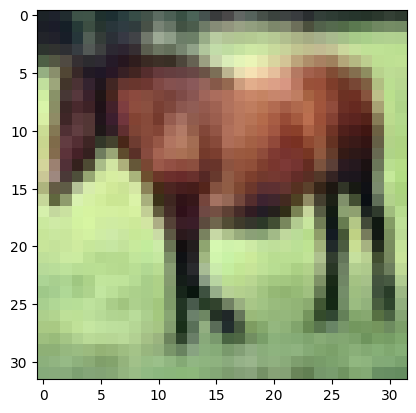

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

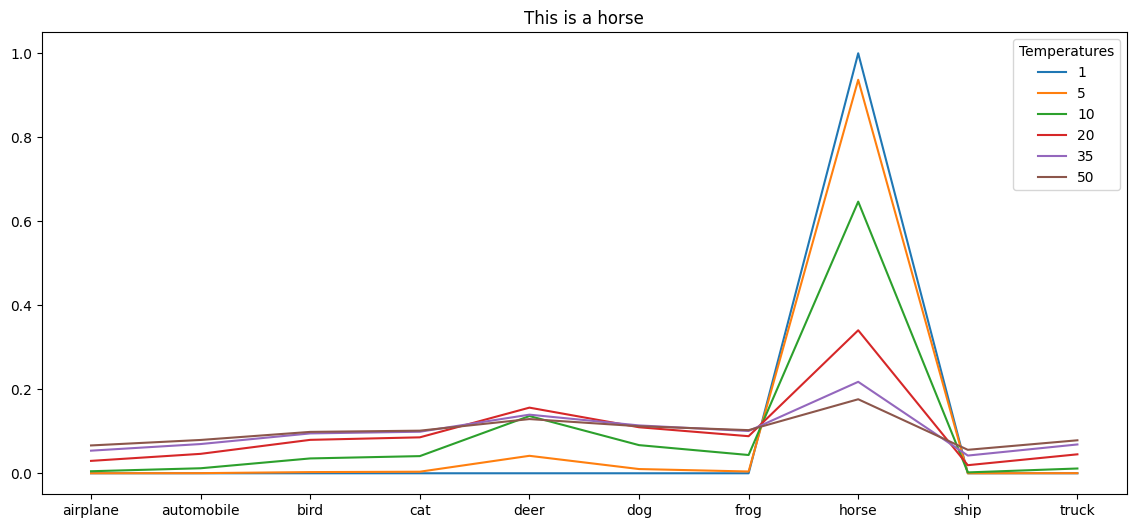

In [ ]:
Teacher_logits = Model(Teacher.input,Teacher.layers[-2].output)

logits_plot = []

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]


# Choose the item to visualize temperature
item_idx = 7

item_image = x_train[item_idx]

plt.imshow(item_image)

Temperatures = [1,5,10,20,35,50]


for Temperature in Temperatures:
  # Create temperature layer that produces logits with temperature
  T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)

  # Create a softmax layer
  Softmax_layer = Softmax()(T_layer)
  # Add the teacher T_layer to the whole model
  Teacher_logits_soften = Model(Teacher.input,Softmax_layer)

  # Append for plotting
  logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))

  plt.figure(figsize=(14, 6))
for i in range(len(Temperatures)):
  plt.plot(class_names,logits_plot[i][0])
  plt.legend(['Temperatures'])
  plt.title('This is a '+ class_names[y_train[item_idx][0]])
  plt.legend(Temperatures,title="Temperatures")

# Create a teacher model that create softened output
As mentioned in **Hinton's paper**:  "When the distilled net had 300 or more units in each of its two hidden layers, all temperatures above gave fairly similar results. But when this was radically reduced to 30 units per layer, temperatures in the range 2.5 to 4 worked significantly better than high or lower temperatures."  
In this notebook, I'll use temperature **3.25**, feel free to change to the Temperature to any number of your interest.

In [ ]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

In [ ]:
# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

313/313 [==============================] - 1s 2ms/step


# Create a student model that produces with and without soften output

The student model we'll in this notebook is a really shallow neural network with only 1 hidden layers with 64 units, followed by a 10 softmax unit for the output

In [ ]:
Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
Student.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                196672    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 197322 (770.79 KB)
Trainable params: 197322 (770.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

<center><img src="https://nervanasystems.github.io/distiller/imgs/knowledge_distillation.png" width=500></center>
<center>

$$ \text{Let } a_{t}  \text{ and } a_{s} \text{ be the logits (the inputs to the final softmax) of the teacher and student network, respectively, with the ground-truth label } y_{r} .\text{ We calculate the cross-entropy between the softmax} (a_{s},y_{r}) \text{ and } y_{r} \text{ as follow:}$$
$$ \mathcal{L}_{SL}=\mathcal{H}(\text{softmax}(a_{s},y_{r})) $$

$$ \text{In knowledge distillation (in all 3 papers), we tries to match the softened outputs of the student } y_{s} = \text{softmax}(a_{s}/\mathcal{T})   \text{ and teacher's softened outputs }  y_{t}=\text{softmax}(a_{t}/\mathcal{T}) \text{via a KL-divergence loss}$$
$$\mathcal{L}_{KD}=\mathcal{T}^2\text{KL}(y_{s},y_{t})$$
$$ \text{The student model will then be trained on a "combined" loss between } \mathcal{L}_{SL} \text{ and } \mathcal{L}_{KD} \text{ with } \lambda \text{ representing the trade off of 2 losses }$$
$$\mathcal{L}_{\text{student}} = \lambda\mathcal{L}_{SL} + (1-\lambda)\mathcal{L}_{KD}$$

In [ ]:
def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)

  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)


In [ ]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])

In [ ]:
myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
333/333 [==============================] - 6s 6ms/step - loss: 6.4183 - accuracy: 0.3095 - val_loss: 5.4444 - val_accuracy: 0.3308
Epoch 2/50
 21/333 [>.............................] - ETA: 1s - loss: 6.0006 - accuracy: 0.3486

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 2s 6ms/step - loss: 5.7630 - accuracy: 0.3725 - val_loss: 5.4029 - val_accuracy: 0.3483
Epoch 3/50
333/333 [==============================] - 1s 4ms/step - loss: 5.5322 - accuracy: 0.3914 - val_loss: 5.3105 - val_accuracy: 0.3535
Epoch 4/50
333/333 [==============================] - 1s 4ms/step - loss: 5.3857 - accuracy: 0.4027 - val_loss: 4.9488 - val_accuracy: 0.3885
Epoch 5/50
333/333 [==============================] - 1s 4ms/step - loss: 5.2441 - accuracy: 0.4133 - val_loss: 4.7603 - val_accuracy: 0.4000
Epoch 6/50
333/333 [==============================] - 1s 4ms/step - loss: 5.1261 - accuracy: 0.4222 - val_loss: 4.7098 - val_accuracy: 0.4048
Epoch 7/50
333/333 [==============================] - 1s 4ms/step - loss: 5.0265 - accuracy: 0.4312 - val_loss: 4.7293 - val_accuracy: 0.3955
Epoch 8/50
333/333 [==============================] - 1s 4ms/step - loss: 4.9397 - accuracy: 0.4362 - val_loss: 4.4418 - val_accuracy: 0.4248
Epoch 9/50
333/33

In [ ]:
StudentModel.load_weights('student.h5')
StudentModel.evaluate(x_train,y_train_new)


1563/1563 [==============================] - 4s 3ms/step - loss: 3.9403 - accuracy: 0.5098


[3.940308094024658, 0.5098000168800354]

# Create a standalone student

In [ ]:
AloneModel = Sequential() #a Must define the input shape in the first layer of the neural netAloneStudent = Sequential() #a Must define the input shape in the first layer of the neural network
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))
AloneModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                196672    
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 197322 (770.79 KB)
Trainable params: 197322 (770.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

myCP = ModelCheckpoint(_best_only=True,filepath='alone.h5',monitor = 'val_acc')

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])


Epoch 1/50
333/333 [==============================] - 2s 5ms/step - loss: 1.9801 - accuracy: 0.2818 - val_loss: 1.8761 - val_accuracy: 0.3273
Epoch 2/50
333/333 [==============================] - 1s 3ms/step - loss: 1.8161 - accuracy: 0.3543 - val_loss: 1.8054 - val_accuracy: 0.3553
Epoch 3/50
333/333 [==============================] - 1s 3ms/step - loss: 1.7699 - accuracy: 0.3722 - val_loss: 1.8051 - val_accuracy: 0.3548
Epoch 4/50
333/333 [==============================] - 1s 3ms/step - loss: 1.7333 - accuracy: 0.3851 - val_loss: 1.7487 - val_accuracy: 0.3871
Epoch 5/50
333/333 [==============================] - 1s 3ms/step - loss: 1.7156 - accuracy: 0.3896 - val_loss: 1.7422 - val_accuracy: 0.3745
Epoch 6/50
333/333 [==============================] - 1s 4ms/step - loss: 1.6955 - accuracy: 0.3982 - val_loss: 1.7200 - val_accuracy: 0.3920
Epoch 7/50
333/333 [==============================] - 2s 5ms/step - loss: 1.6754 - accuracy: 0.4069 - val_loss: 1.7349 - val_accuracy: 0.3816
Epoch 

In [ ]:
AloneModel = load_model("alone.h5")
AloneModel.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.6120 - accuracy: 0.4314


[1.6119868755340576, 0.43140000104904175]

# References
[Nervanasystem github's
](https://nervanasystems.github.io/distiller/knowledge_distillation.html)

[Hinton et. al. -
Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)

[Seyed-Iman Mirzadeh et. al. - Improved Knowledge Distillation via Teacher Assistant:Bridging the Gap Between Student and Teacher](https://arxiv.org/abs/1902.03393)

In [ ]:
2+2

4